In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [127]:
data_raw = []
with open("datatrain2M.csv") as f:
    for line in f:
        piece = eval(line)
        if max(piece)<7 :
            data_raw.append(piece)

In [242]:
import json 
data7 = []
with open("train7.json",'r') as f:
    data7 = json.load(f)

In [205]:
dataset = np.array(data4)
# 输入范围0-15，除以16做归一化
images = (dataset[:,:-1]/16).astype("float32")
labels = dataset[:,-1].astype("uint8")

In [206]:
images.shape

(33995, 64)

In [207]:
# Training Parameters
learning_rate = 0.0001
num_steps = 10000
batch_size = 128

# Network Parameters
num_input =  64# MNIST data input (img shape: 28*28)
num_classes = 4 # MNIST total classes (0-9 digits)
dropout = 0.5 # Dropout, probability to drop a unit

In [208]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 8, 8, 1])

        # Convolution Layer with 32 filters and a kernel size of 3
        conv1 = tf.layers.conv2d(x, 32, 4, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        #conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        #conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [209]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [210]:
# Build the Estimator
tf.logging.set_verbosity(tf.logging.INFO)
model = tf.estimator.Estimator(model_fn=model_fn,model_dir="./mymodels/model4")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './mymodels/model4', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100}


In [230]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, y=labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=10000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-120000
INFO:tensorflow:Saving checkpoints for 120001 into ./mymodels/model4/model.ckpt.
INFO:tensorflow:loss = 0.5528741, step = 120001
INFO:tensorflow:global_step/sec: 26.3971
INFO:tensorflow:loss = 0.700449, step = 120101 (3.791 sec)
INFO:tensorflow:global_step/sec: 17.3393
INFO:tensorflow:loss = 0.569626, step = 120201 (5.769 sec)
INFO:tensorflow:global_step/sec: 27.5837
INFO:tensorflow:loss = 0.61729074, step = 120301 (3.622 sec)
INFO:tensorflow:global_step/sec: 24.0129
INFO:tensorflow:loss = 0.59306914, step = 120401 (4.167 sec)
INFO:tensorflow:global_step/sec: 30.9216
INFO:tensorflow:loss = 0.62096107, step = 120501 (3.232 sec)
INFO:tensorflow:global_step/sec: 27.6284
INFO:tensorflow:loss = 0.6714061, step = 120601 (3.622 sec)
INFO:tensorflow:global_step/sec: 26.6063
INFO:tensorflow:loss = 0.60257494, step = 120701 (3.757 sec)
INFO:tensorflow:global_step/sec: 32.5635

In [231]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, y=labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2018-12-13-14:12:43
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
INFO:tensorflow:Finished evaluation at 2018-12-13-14:12:46
INFO:tensorflow:Saving dict for global step 130000: accuracy = 0.76281804, global_step = 130000, loss = 0.58623785


{'accuracy': 0.76281804, 'global_step': 130000, 'loss': 0.58623785}

INFO:tensorflow:Restoring parameters from ./mymodels/model3/model.ckpt-113000


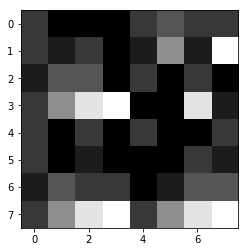

Model prediction: 2


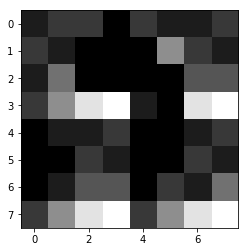

Model prediction: 0


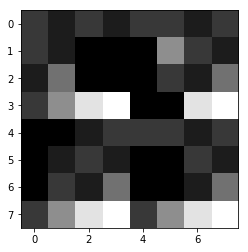

Model prediction: 3


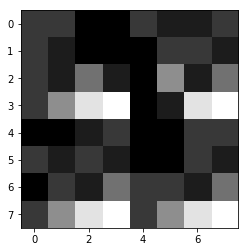

Model prediction: 2


In [21]:
# Predict single images
n_images = 4
# Get images from test set
test_images = images[1000:1000+n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [8, 8]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

In [122]:
from game2048.game import Game
from game2048.displays import Display, IPythonDisplay
from game2048.agents import Agent, RandomAgent, ExpectiMaxAgent
# from game2048.displayer import Displayer
display1 = Display()
display2 = IPythonDisplay()

In [232]:
import math
class MyAgent(Agent):

    def __init__(self, game, display=None):
        super().__init__(game, display)
        self.testgame = Game(4, random=False)
        self.testgame.enable_rewrite_board = True
        
    def step(self):
        cur_board = self.game.board
        
        buf = []
        for d in range(4):
            self.testgame.board = cur_board
            self.testgame.move(d)
            buf.append(self.testgame.board.astype(int))
            #print(buf[d])
        tmp = np.vstack((np.hstack((buf[0],buf[3])) ,np.hstack((buf[1],buf[2])))).flatten().tolist()
        new = [int(math.log(i,2)) if i>0 else i for i in tmp]
        img = np.array(new).astype("float32")/16
        imgs = np.array(img)
        input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': imgs}, shuffle=False)
        preds = list(model.predict(input_fn))

        direction = preds[0]
        return direction


In [234]:
game = Game(4, random=False)
agent = MyAgent(game, display=display1)
agent.play(verbose=True)

INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
Iter: 1
======Direction: up======
State:	       0       2       0       2
	       0       4       0       0
	       0       0       0       0
	       0       0       0       0
Score: 4
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
Iter: 2
======Direction: up======
State:	       0       2       0       2
	       0       4       0       0
	       4       0       0       0
	       0       0       0       0
Score: 4
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
Iter: 3
======Direction: left======
State:	       4       0       0       0
	       4       0       0       2
	       4       0       0       0
	       0       0       0       0
Score: 4
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
Iter: 4
======Direction: left======
State:	       4       0       0       0
	       4       2       0       4
	       4       0    

In [67]:
cur_board

array([[4., 4., 2., 2.],
       [2., 2., 4., 4.],
       [0., 0., 2., 2.],
       [0., 0., 0., 0.]])

In [241]:
testgame = Game(4, random=False)
testgame.enable_rewrite_board = True
cur_board = testgame.board
agent1 = MyAgent(testgame, display=None)
agent2 = ExpectiMaxAgent(testgame, display=None)

err = 0
for i in range(100):
    cur_board = testgame.board
    step1 = agent1.step()
    testgame.board = cur_board
    step2 = agent2.step()
    testgame.move(step2)
    if(step1!=step2):
        err += 1
    
err

INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000
INFO:tensorflow:Restoring parameters from ./mymodels/model4/model.ckpt-130000


KeyboardInterrupt: 